The purpose of this notebook is to implement the matrix factorization model : 
    https://datajobs.com/data-science-repo/Recommender-Systems-%5BNetflix%5D.pdf

## Import all the needed packages

In [31]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

## Download the data

In [110]:
## Data from Movielens100k 
r_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=r_cols,
                      encoding='latin-1')

In [3]:
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


## Remove the undisired last column

In [111]:
ratings = ratings.drop('unix_timestamp',axis=1)

In [112]:
ratings.head()

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


# Data Exploration 

In [27]:
ratings.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [123]:
users_maxid = ratings.loc[ratings['user_id'].idxmax()]
items_maxid = ratings.loc[ratings['movie_id'].idxmax()]
nb_users = users_maxid[0] ; nb_items = items_maxid[1] 
print("number of users : ",nb_users)
print("number of items : ",nb_items)

number of users :  943
number of items :  1682


## Distribution of number of ratings for each user

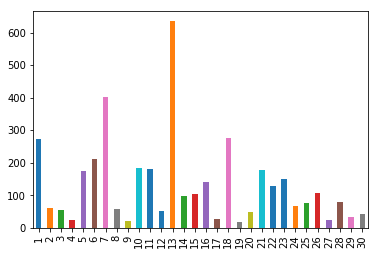

In [38]:
ratings['user_id'].value_counts().sort_index().head(30).plot.bar()

In [42]:
ratings['user_id'].value_counts().describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: user_id, dtype: float64

## Discribution of number of ratings for each movie

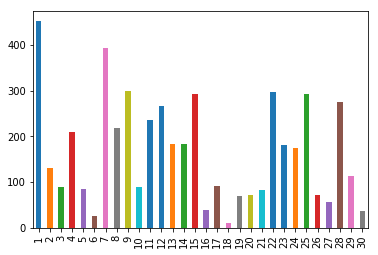

In [40]:
ratings['movie_id'].value_counts().sort_index().head(30).plot.bar()

In [56]:
ratings['movie_id'].value_counts().describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: movie_id, dtype: float64

## Rating Histogram

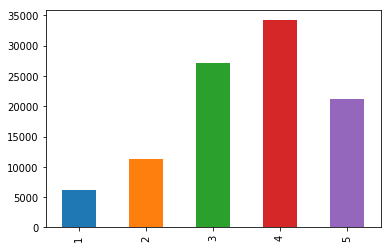

In [44]:
ratings['rating'].value_counts().sort_index().head(30).plot.bar()

## Split the whole data set to training and val data

In [196]:
## Doing this, we keep the same caracteristics of the initial rating matrix(one can plot the same figure to be sure ...)
train=ratings.sample(frac=0.7,random_state=10)

In [197]:
## Create the rating matrices
train_matrix = train.pivot(index='user_id', columns='movie_id', values='rating')

In [198]:
## Find the missing index ( When doing the split based on ratings some movies or users could may be disappear ... )
idx = pd.Index(np.arange(1,1683,1))
idx_to_add = idx.difference(train_matrix.columns)
for i in idx_to_add:
    train_matrix[i] = np.nan
train_matrix = train_matrix.reindex(sorted(train_matrix.columns), axis=1)

In [205]:
## Same procedure for the val data

In [200]:
val=ratings.drop(train.index)

In [201]:
val_matrix = val.pivot(index='user_id', columns='movie_id', values='rating')

In [203]:
idx = pd.Index(np.arange(1,1683,1))
idx_to_add = idx.difference(val_matrix.columns)
for i in idx_to_add:
    val_matrix[i] = np.nan
val_matrix = val_matrix.reindex(sorted(train_matrix.columns), axis=1)

In [211]:
## Boolean Matrices of missing values 
train_missing_entries = train_matrix.notnull()
val_missing_entries = val_matrix.notnull()
## Transform the matrices to numpy arrays
train_rating_matrix = train_matrix.values
val_rating_matrix = val_matrix.values

## Create the rating matrix in COO Format

In [212]:
ratings_matrix_COO = ratings.values

## Create the Boolean mask tensorflow variable for the missing values

In [214]:
training_tf_mask = tf.Variable(train_missing_entries.values)
val_tf_mask = tf.Variable(val_missing_entries.values)

In [215]:
mu = ratings_matrix_COO[:,2].mean()

## Initialize the matrix factors to learn, from random normals with mean 0. U will represent users and I will represent items and determine the rank of number of factors to learn

In [216]:
## Initialize the number of users and items and the rank of our latent factors
num_users = nb_users;num_items = nb_items;rank = 5

U = tf.Variable(tf.random_normal([num_users, rank], stddev=0.1, dtype=tf.float64), dtype=tf.float64,
                name="users_Matrix")
I = tf.Variable(tf.random_normal([rank, num_items], stddev=0.1, dtype=tf.float64), dtype=tf.float64,
                name="items_Matrix")

## Add the bias term (mean of user's ratings in U and mean of item's ratings in I)

In [217]:
### Compute the user bias
user_bias = np.zeros((num_users,1))
k_user = np.zeros((num_users,1))
for i in range(len(ratings_matrix_COO)):
    current_user_id = ratings_matrix_COO[i,0]
    user_bias[current_user_id-1,0] += ratings_matrix_COO[i,2]
    k_user[current_user_id-1,0] += 1
for i in range(len(user_bias)):
    user_bias[i,0] = user_bias[i,0]/k_user[i,0]

### Compute the item bias
item_bias = np.zeros((num_items,1))
k_item = np.zeros((num_items,1))
for i in range(len(ratings_matrix_COO)):
    current_item_id = ratings_matrix_COO[i,1]
    item_bias[current_item_id-1,0] += ratings_matrix_COO[i,2]
    k_item[current_item_id-1,0] += 1
for i in range(len(item_bias)):
    item_bias[i,0] = item_bias[i,0]/k_item[i,0]
item_bias = np.transpose(item_bias)

In [218]:
bias_U = tf.concat([U, tf.convert_to_tensor(user_bias, dtype=tf.float64, name="user_bias"),
                         tf.ones((num_users,1), dtype=tf.float64, name="eyes_row_items")],axis=1)

bias_I = tf.concat([I, tf.ones((1, num_items), name="eyes_column_item", dtype=tf.float64),
                         tf.convert_to_tensor(item_bias, dtype=tf.float64, name="item_bias")],axis=0)

# Multiply the factors to get our rating matrix
R = tf.cast(tf.matmul(bias_U, bias_I), tf.float64)

## Define the Error to minimize

In [220]:
training_error = tf.subtract(tf.boolean_mask(tf.add(R,mu), training_tf_mask),
                         tf.boolean_mask(train_rating_matrix, training_tf_mask),
                         name="training_error")
val_error = tf.subtract(tf.boolean_mask(tf.add(R,mu), val_tf_mask),
                          tf.boolean_mask(val_rating_matrix, val_tf_mask),
                          name="validation_error")

## Define the different scopes 

In [221]:
## The threshold to compute the accuracy(pred_score - true_score < threshold => acc = 1)
accuracy_threshold = 0.5

## the regularizer term (Set empirically)
landa = 4

## Number of training and val Data (see the split above)
n_training = len(train)
n_val = len(val)

with tf.name_scope("training_cost") as scope:
    
    ## Frobenius norm
    training_f_norm = tf.reduce_sum(tf.square(training_error), name="Frobenius_Norm")
    
    ## Add regularizer term
    regularizer = tf.multiply(tf.add(tf.reduce_sum(tf.square(bias_U)), tf.reduce_sum(tf.square(bias_I))),
                              landa, name="regularizer_term")
    ## the cost is f_norm + reg term
    training_cost = tf.add(training_f_norm, tf.cast(regularizer,tf.float64), name="training_cost")/n_training

with tf.name_scope("validation_cost") as scope:
    
    val_cost = tf.reduce_sum(tf.square(val_error), name="valdiation_error")/n_val

with tf.name_scope("train") as scope:
    optimizer = tf.train.AdamOptimizer(0.1)
    optimize = optimizer.minimize(training_cost)

with tf.name_scope("training_accuracy") as scope:
    training_truth = tf.less(tf.abs(training_error), accuracy_threshold)
    training_acc = tf.reduce_sum(tf.cast(training_truth, tf.float32))/n_training
    training_accuracy_summary = tf.summary.scalar("training_accuracy", training_acc)

with tf.name_scope("validation_accuracy") as scope:
    val_truth = tf.less(tf.abs(val_error), accuracy_threshold)
    val_acc = tf.reduce_sum(tf.cast(val_truth, tf.float32))/n_val
    val_accuracy_summary = tf.summary.scalar("validation_accuracy", val_acc)

## Create a tensorflow session and run All

In [223]:
# Create a TensorFlow session and initialize variables.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    # Make sure summaries get written to the logs.
    summary_op = tf.summary.merge_all()
    writer = tf.summary.FileWriter("matrix_factorization_logs", sess.graph)
    steps = 1000
    for i in range(steps):
        sess.run(optimize)
        result = sess.run([summary_op, training_acc, training_cost, val_acc, val_cost])
        writer.add_summary(result[0], i)
        if i % 200== 0:
            print("Training accuracy at step %s: %s" % (i, result[1]))
            print("Training cost: %s" % (result[2]))
            print("Validation accuracy at step %s: %s" % (i, result[3]))
            print("Validation cost: %s" % (result[4]))  
            print("*"*40)
    learnt_U = sess.run(U)
    learnt_I = sess.run(I)
    R_Final = sess.run(R)

Training accuracy at step 0: 0.0
Training cost: 52.49075793091747
Validation accuracy at step 0: 0.0
Validation cost: 50.65210828191615
****************************************
Training accuracy at step 200: 0.45594287
Training cost: 3.512063284585756
Validation accuracy at step 200: 0.41613334
Validation cost: 1.0338996156420994
****************************************
Training accuracy at step 400: 0.47415715
Training cost: 3.4709768964879624
Validation accuracy at step 400: 0.4208
Validation cost: 1.0479576808203614
****************************************
Training accuracy at step 600: 0.47732857
Training cost: 3.4573274894138795
Validation accuracy at step 600: 0.41796666
Validation cost: 1.0468733025545103
****************************************
Training accuracy at step 800: 0.47678572
Training cost: 3.4513269419370265
Validation accuracy at step 800: 0.41726667
Validation cost: 1.0454151317883986
****************************************


## Print the resulting matrix and te

In [238]:
for i in range(20):
    true_rate = train_rating_matrix[0,i]
    pred_rate = R_Final[0,i] + mu
    if not(np.isnan(true_rate)):
        print(true_rate,pred_rate)

5.0 3.8793803075455795
3.0 3.0257768926930537
3.0 3.9279349334698543
3.0 2.945910797070669
5.0 4.08516138207251
1.0 3.4022229845647987
3.0 3.317138496183163
2.0 3.585789731583922
5.0 4.981267892245202
5.0 3.1673363151763487
5.0 3.214005957315482
3.0 3.12923730263628
4.0 3.7344006042188473
5.0 3.73795181269588
